In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Assumes scale images are on your Drive under "Images"

!ls /content/drive/MyDrive/Images/*csv

/content/drive/MyDrive/Images/labels.csv
/content/drive/MyDrive/Images/SalmonFishScalesCoordinates-V2.csv


In [ ]:
import os.path
import numpy as np
import math
from matplotlib.image import imread
import matplotlib.pyplot as plt
import skimage.draw as drw

SCALE_WIDTH = 1500
SCALE_HEIGHT = 2000
IMAGE_HEIGHT = 1920
TRANSECT_LENGTH = 750

PATH=os.sep + os.path.join("content", "drive", "MyDrive", "Images")

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def fill_boarder(gray_img, thickness, fill_value=255):
  gray_img[:thickness,:] = fill_value
  gray_img[-thickness:,:] = fill_value
  gray_img[:,:thickness] = fill_value
  gray_img[:,-thickness:] = fill_value

def scale_edge_detector(x,index, window_size, frequency_factor, orientation):
  if not (orientation == 'LR' or orientation == 'RL'):
    raise Exception("Edge detection orientation must be 'LR' or 'RL'.")

  if window_size % 2 != 1:
    raise Exception("Window size must be an odd number.")

  l_sum = np.sum(x[index - int(window_size / 2): index])
  r_sum = np.sum(x[index + 1: index + int(window_size / 2)])

  if orientation == 'LR':
    if r_sum > l_sum * frequency_factor:
      return True
    else:
      return False
  else:
    if r_sum * frequency_factor > l_sum:
      return True
    else:
      return False

def mask1d(gray_img, kernel_size, threshold=20):
  if kernel_size % 2 != 1:
    raise Exception("Kernel size must be an odd number.")


  mask = np.zeros(gray_img.shape, dtype=np.uint8)
  filter = np.ones(kernel_size) / kernel_size

  for y in range(gray_img.shape[0]):
    delta = np.convolve(gray_img[y,:], filter, mode='same') - gray_img[y,:]
    mask[y, (np.abs(delta) > threshold)] = 255.

  return mask

def mask(gray_img, kernel_size, threshold=20):
  if kernel_size % 2 != 1:
    raise Exception("Kernel size must be an odd number.")

  xd = mask1d(gray_img, 9, 20)
  yd = mask1d(np.transpose(gray_img), 9, 20).transpose()
  mask = xd /2 + yd / 2

  return mask

def denoise(gray_img, kernel_size, percent_activated_threshold=0.4):
  if kernel_size % 2 != 1:
    raise Exception("Kernel size must be an odd number.")

  activation_cutoff = percent_activated_threshold * kernel_size * kernel_size * 255
  denoised_img = gray_img.copy()

  for j in range(int(kernel_size / 2), gray_img.shape[0] - int(kernel_size / 2)):
    for k in range(int(kernel_size / 2), gray_img.shape[1] - int(kernel_size / 2)):
      if gray_img[j, k] > 120:
        if np.sum(gray_img[j:j+kernel_size,k:k+kernel_size]) < activation_cutoff:
          denoised_img[j, k] = 0

  return denoised_img

def detect_scale_contour(gray_img, padding=25):
  contour = []

  for j in range(padding, gray_img.shape[0] - padding):
    k = padding
    k_min = padding

    # Burn in period to make sure we are not detecting a scale on the edge
    while k < gray_img.shape[1] - padding and np.sum(gray_img[j, k-10:k+25]) > 30 * 255:
      k = k + 1

    while k < gray_img.shape[1] - padding:
      if gray_img[j, k] > 0 and scale_edge_detector(gray_img[j,:], k, 25, 5, 'LR'):
        contour.append((j, k))
        k_min = k
        k = gray_img.shape[1] - padding
      k = k + 1

    # Burn in period to make sure we are not detecting a scale on the edge
    while k > k_min and np.sum(gray_img[j, k-25:k+10]) > 30 * 255:
      k = k - 1

    while k > k_min:
      if gray_img[j, k] > 0 and scale_edge_detector(gray_img[j,:], k, 25, 5, 'RL'):
        contour.append((j, k))
        k = 0
      k = k - 1

  return contour

def dilate_contour(contour, thickness):

  dialated_contour = set()
  for (j, k) in contour:
    for l in range(j - thickness, j + thickness):
      for m in range(k - thickness, k + thickness):
        dialated_contour.add((l, m))

  return list(dialated_contour)

def draw_box(gray_img, top_left_point, bottom_right_point, color=255):
  j1, k1 = top_left_point
  j2, k2 = bottom_right_point

  gray_img[j1,k1:k2+1] = color
  gray_img[j2,k1:k2+1] = color
  gray_img[j1:j2+1,k1] = color
  gray_img[j1:j2+1,k2] = color

def draw_line(gray_img, mid_point, end_point, color=255):

  rr, cc = drw.line(*mid_point, *end_point)
  gray_img[rr, cc] = color

def draw_contour(size, contour, color=255):

  img = np.zeros(size, dtype=np.uint8)
  for (j, k) in contour:
    img[j, k] = color

  return img

def load_img_to_gray(file):
  img = imread(file)
  gray = rgb2gray(img)

  return gray

def show_image_and_contour(gray):

  plt.imshow(gray, cmap=plt.get_cmap('gray'))
  plt.show()

  masked_image = mask(gray, 9, 20)
  denoised_mask = denoise(masked_image, 101, .025)

  contour = detect_scale_contour(denoised_mask, 100)
  dilated_contour = dilate_contour(contour, 5)
  drawn_contour = draw_contour(denoised_mask.shape, dilated_contour)

  plt.imshow(np.abs(drawn_contour - 255), cmap=plt.get_cmap('gray'))
  plt.show()

def frame_image_w_mean(gray, j_m, k_m):
  mean_pixel_value = np.mean(gray)

  if j_m - SCALE_HEIGHT // 2 > 0:
    gray[0:j_m - SCALE_HEIGHT // 2,:] = mean_pixel_value
    gray[j_m + SCALE_HEIGHT // 2:,:] = mean_pixel_value

  if k_m - SCALE_WIDTH // 2 > 0:
    gray[:, 0:k_m - SCALE_WIDTH // 2] = mean_pixel_value
    gray[:,k_m + SCALE_WIDTH // 2:] = mean_pixel_value

  #return gray

def calculate_transect_endpoint(mid_point, offset, length):
  """
  Given an offset from a line extending direclty down from the
  mid-point, determine the coordinates of the other endpoint of
  a line that starts at the mid-point and extends in the direction
  of the offset of specified length

  :param mid_point: the coordinates of the mid-point in row-major format
  :param offset: offset angle in radians from 6 o'clock applied counter-clockwise
  :param length: describe about parameter p3
  :return: the coordinates of the endpoint in row-major format
  """
  j, k = mid_point

  return (j + int(length * math.cos(offset)),
          k + int(length * math.sin(offset)))

def calculate_transect_angle(mid_point, end_point):
  """
  Given two points, calculated the angle between a line that
  extends down from the mid-point, opens counter-clockwise
  to the line that is defined by the mid_point and end_point

  :param mid_point: the coordinates of the mid-point in row-major format
  :param end_point: the coordinates of the end-point of the transect
     in row-major format
  :return: angle in radians
  """

  offset = 0

  # if the transect angle is at pi/2 or 3 pi/2, the atan will be undefined
  if abs(mid_point[0] - end_point[0]) < 1e-5:
    if mid_point[0] < end_point[0]:
      offset = math.pi / 2
    else:
      offset = 3 * math.pi / 2

  else:
    offset = math.atan((mid_point[1] - end_point[1]) /
                       (mid_point[0] - end_point[0]))

    # if end point is above mid point, add pi to offset as it would have
    #  been caculated relative to line extending above mid point.
    if(end_point[0] < mid_point[0]):
      offset = offset + math.pi

    # if offset is negative, add to 2pi
    if(end_point[1] < mid_point[1]):
      offset = 2 * math.pi + offset

  return offset

def calculate_coordinates_of_transects(mid_point, transect_angle, offset_step_size, transect_count):
  """
  Determine the coordintates of points along transect lines at specified offsets
  from an initial trasect.

  :param mid_point: the coordinates of the mid-point in row-major format
  :param offset: transect angle in radians from 6 o'clock applied counter-clockwise
  :param offset_step_size: Offset in radians between transects
  :param transect_count: The number of transects to generate in addition to
    main transect
  :return: a list of lists containing the coordinates of points on transects
    extending out from the mid_point.  Indexing of transects alternates out
    from main transect.
  """
  transects_coordinates = []
  calculate_transect_endpoint(mid_point, transect_angle, TRANSECT_LENGTH)
  transects_coordinates.append(drw.line(*mid_point,
                                        *calculate_transect_endpoint(mid_point, transect_angle, TRANSECT_LENGTH))
                               )

  for offset in [o for i in range(1, int(transect_count / 2) + 1) for o in (i * offset_step_size, -i * offset_step_size)]:
    transects_coordinates.append(drw.line(*mid_point,
                                          *calculate_transect_endpoint(mid_point, transect_angle + offset, TRANSECT_LENGTH))
                                 )

  return transects_coordinates

def draw_transects(gray_img, transects_coordinates, color = 250):
  """
  Draws transects on a copy of grayscale image.

  :param gray_img: 2d array of a grayscale image
  :param trasects_coordinates: a list of lists containing the coordinates of points on transects
    extending out from the mid_point.  Indexing of transects alternates out
    from main transect.
  :param color: pixel value for drawn transect
  :return: 2d array representing grayscale image with transects applied
  """
  img_w_transects = np.copy(gray_img)
  j_max = gray_img.shape[0]
  k_max = gray_img.shape[1]

  for i, transect in enumerate(transects_coordinates):
    rr, cc = transect
    rr[rr >= j_max] = j_max - 1
    cc[cc >= k_max] = k_max - 1

    img_w_transects[rr, cc] = color

  return img_w_transects

def extract_transects_signals(gray_img, transects_coordinates):

  transect_signals = []
  for i, transect in enumerate(transects_coordinates):
    signal = []
    rr, cc = transect
    for j, k in zip(rr, cc):
      signal.append(gray_img[j, k])
    transect_signals.append(signal)

  return transect_signals

def convolve_transects_signals(transects_signals, kernel_size):

  filter = np.ones(kernel_size) / kernel_size
  convolved_signals = []

  for signal in transects_signals:
    convolved_signals.append(convolve_transects_signal(signal, kernel_size))

  return convolved_signals

def convolve_transects_signal(transects_signal, kernel_size):

  filter = np.ones(kernel_size) / kernel_size
  signal_length = max(len(transects_signal), kernel_size) - min(len(transects_signal), kernel_size) + 1
  offset = int((len(transects_signal) - signal_length) / 2)
  return(np.convolve(transects_signal, filter, mode='valid') - transects_signal[offset:-offset])


def plot_transect_signals(transects_signals, figure_path, figure_filename):
  n = len(transects)

  fig, axes = plt.subplots(2 * n)
  for i, signal in enumerate(transects_signals):
    axes[i].plot(signal)

  convolved_signals = convolve_transects_signals(transects_signals, 5)
  for i, signal in enumerate(convolved_signals):
    axes[i + n].plot(signal)

  fig.savefig(os.path.join(figure_path, figure_filename +".png"), format="png",
              bbox_inches="tight")

def plot_transect_signals_for_image(filepath, mid_point, transect_angle,
                                    offset_step_size, transect_count,
                                    figure_path):
  gray = load_img_to_gray(filepath)
  filename = os.path.splitext(os.path.basename(filepath))[0]

  transects = calculate_coordinates_of_transects(mid_point, transect_angle,
                                                 offset_step_size, transect_count)
  transects_signals = extract_transects_signals(gray, transects)

  plot_transect_signals(transects_signals, figure_path, filename)


In [ ]:
import pandas as pd
from ast import literal_eval

scale_data = pd.read_csv('/content/drive/MyDrive/Images/SalmonFishScalesCoordinates-V2.csv', sep=",",
                          names=['filename', 'lt_center', 'br_center', 'end_point'],
                          dtype={'filename': 'string'},
                          converters={'lt_center': literal_eval,
                                      'br_center': literal_eval,
                                      'end_point': literal_eval},
                          header=0)
scale_data['filepath'] = scale_data.apply(lambda row: os.path.join(PATH, row['filename']) +  ".tif", axis=1)

# Switch from column-major to row major
scale_data['lt_center'] = scale_data.apply(lambda row: (row['lt_center'][1], row['lt_center'][0]) , axis = 1)
scale_data['br_center'] = scale_data.apply(lambda row: (row['br_center'][1], row['br_center'][0]) , axis = 1)
scale_data['end_point'] = scale_data.apply(lambda row: (row['end_point'][1], row['end_point'][0]) , axis = 1)

scale_data['mid_center'] = scale_data.apply(lambda row: (int((row['lt_center'][0] + row['br_center'][0]) / 2),
                                                         int((row['lt_center'][1] + row['br_center'][1]) / 2)) , axis=1)
scale_data['transect_angle'] = scale_data.apply(lambda row: calculate_transect_angle(row['mid_center'], row['end_point']), axis=1)

scale_data['id'] = scale_data.apply(lambda row: int(row['filename'].split('_')[0]), axis=1)

# Bring in labels
label_data = pd.read_csv('/content/drive/MyDrive/Images/labels.csv', sep=",",
                          names=['id', 'age', 'type', 'fold'],
                          dtype={'filename': 'int64', 'age': 'int32', 'type': 'int32', 'fold': 'int32'},
                          header=0)

# Fold in labels with scale data
scale_data = scale_data.merge(label_data, on='id', how='left', validate='many_to_one')

# Drop any rows with NaNs, recast ints
scale_data = scale_data.dropna().astype({'fold': int, 'type': int})

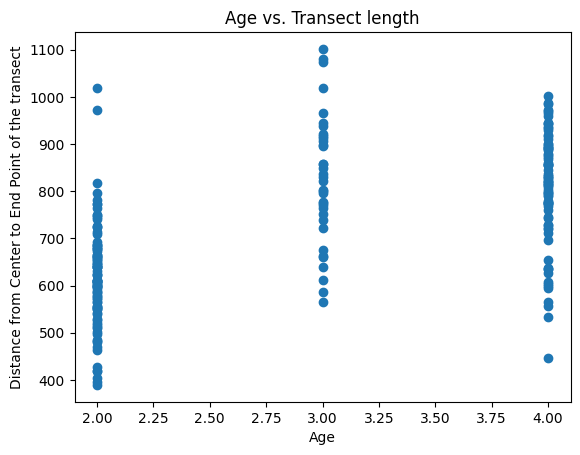

In [ ]:
import math

# Function to calculate distance between two points
def calculate_distance(point1, point2):
    return math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)

# Calculate distance between mid_center and end_point
scale_data['distance_mid_to_end'] = scale_data.apply(lambda row: calculate_distance(row['mid_center'], row['end_point']), axis=1)

# Create scatter plot of age vs. distance
plt.scatter(scale_data['age'], scale_data['distance_mid_to_end'])
plt.xlabel('Age')
plt.ylabel('Distance from Center to End Point of the transect')
plt.title('Age vs. Transect length')
plt.show()
